# 1. Look at the big picture

- Frame the Problem
    - first question to ask your boss is what exactly the business objective is
    - Your boss answers that your model’s output (a prediction of a district’s median housing price)
    - next question to ask your boss is what the current solution looks like (if any)
    - current situation will often give you a reference for performance, as well as insights on how to solve the problem
    - frame the problem:
        - is it supervised, unsupervised, or Reinforcement Learning?
        - Is it a classification task, a regression task, or something else?
        - Should you use batch learning or online learning techniques?
    - in our case its **supervised - univariate multiple regression - batch learning**

# 2. Get the Data

## 2.1 Download the data

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path, filter="data")

In [2]:
fetch_housing_data()

## 2.2 Load the data

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## 2.3 Quick look of data

### 2.3.1 Using `df.head()`

In [4]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

### 2.3.2 Description of data using `df.info()`

In [5]:
housing.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.6 MB


### 2.3.3 Categorical attribute using `df['cat_attrib_col'].value_counts()`

In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### 2.3.4 Summary of numerical attributes using `df.describe()`

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

### 2.3.5 Histogram to feel the data using `df.hist()`

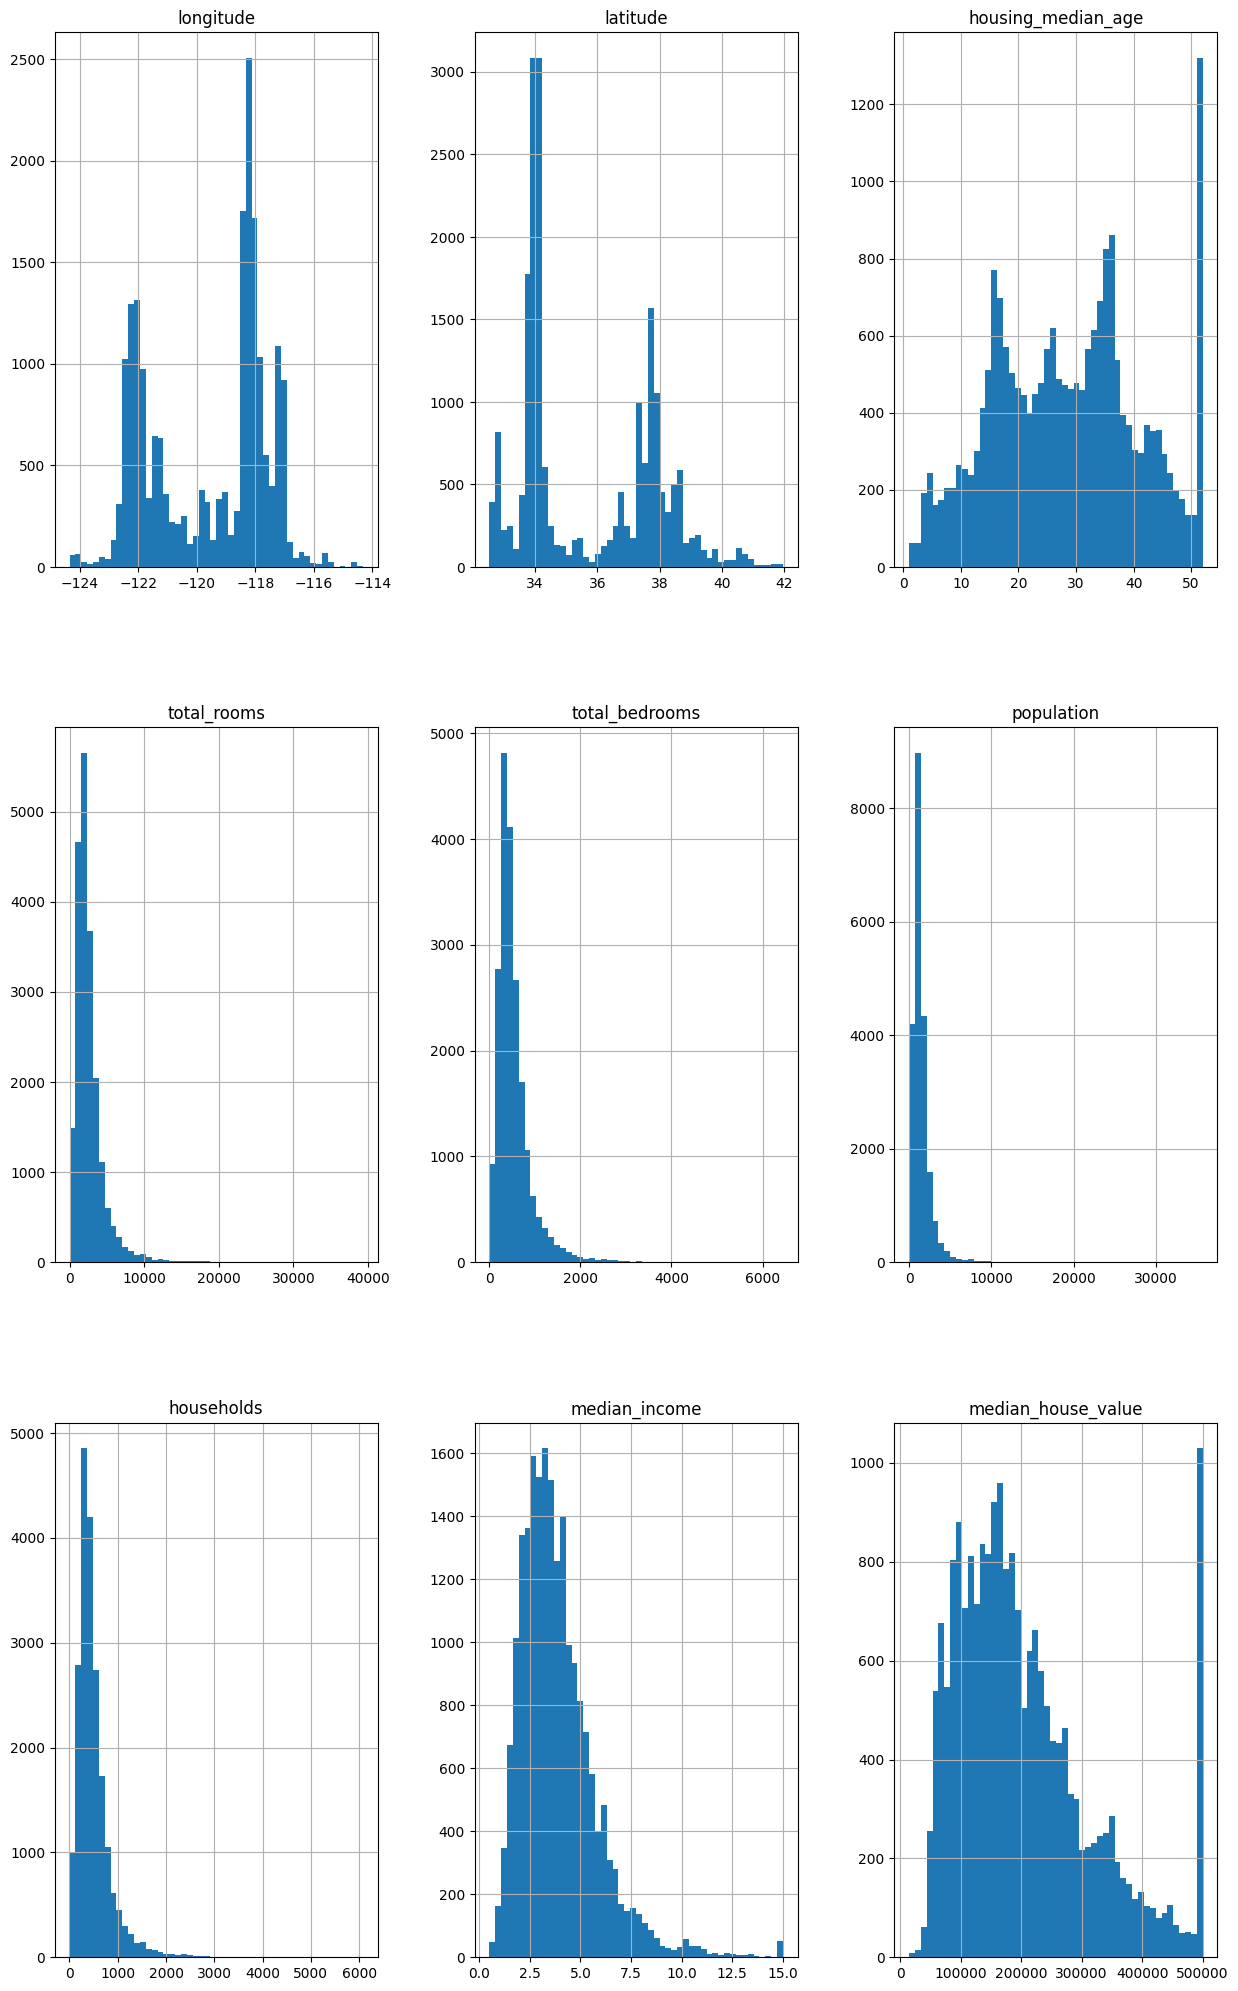

In [8]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(15,25))
plt.show()

### 2.3.6 Insigths from plot
- `medium income` attribute roughly represented tens of thousands of dollars ie **pre processed attribute**
- `housing median age` and `median house value` were capped may turn serious (since its target). ML algo **may learn that prices never go beyond that limit**. We need to check whether they want precise predictions beyond $500k then we can do following
    - collect proper labels for districts whose labels were capped
    - remove those districts from training and testing sets
- attributes have very different scales
- histograms were **tail-heavy** they extend much further to right of median that to left. This makes bit harder for ml algo to detect patterns. Therefore later we perform transformations to have more bell shaped distributions

## 3. Creating Test Set

### 3.1 pick some random instances typically 20% of dataset (gen diff when run multiple times)

In [9]:
import numpy as np
def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = train_test_split(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


### 3.2 resolving V1 issue using `np.seed()` (fails with updated dataset)

In [11]:
def train_test_split(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = train_test_split(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


### 3.3 Use instance identifier to decide to include in test set or not

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier).tobytes()) & 0xffffffff < test_ratio * 2**32

In [14]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### 3.3.1 Use row index as unique identifier

In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
print(len(train_set), len(test_set))

16512 4128


#### 3.3.2 Use (lat, long) as unique identifier

In [17]:
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [18]:
print(len(train_set), len(test_set))

16322 4318


### 3.4 Using sklearn `train_test_split()`

In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [20]:
print(len(train_set), len(test_set))

16512 4128


### 3.5 Implementing Stratified sampling based `median_income`

In [21]:
bins = np.linspace(0, 6, 5)
bins = np.append(bins, np.inf)
labels = range(1,6)
print(bins)
print(labels)

[0.  1.5 3.  4.5 6.  inf]
range(1, 6)


#### 3.5.1 `pd.cut()` function to binning numerical attribute given bins

In [22]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=bins, labels=labels)

In [23]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

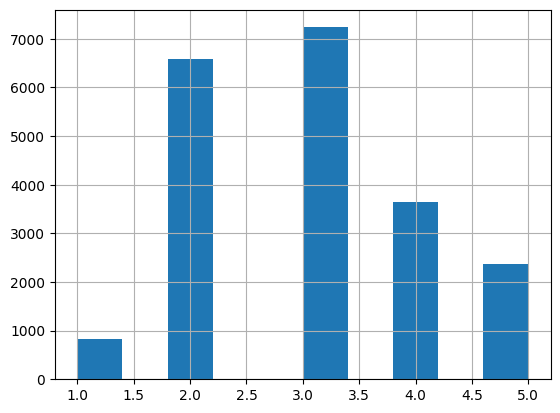

In [24]:
housing["income_cat"].hist()

#### 3.5.2 Using Scikit-learn's `StratifiedShuffleSplit` class

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

### 3.6 Sampling bias comparision of stratified vs purely random sampling

In [27]:
test_set["income_cat"] = pd.cut(test_set["median_income"], bins=bins, labels=labels)

overall = housing["income_cat"].value_counts(normalize=True).sort_index()
random_test = test_set["income_cat"].value_counts(normalize=True).sort_index()
strat_test = strat_test_set["income_cat"].value_counts(normalize=True).sort_index()

compare = pd.DataFrame({
    "Overall %": overall,
    "Random %": random_test,
    "Stratified %": strat_test,
})

compare["Random Error %"] = 100 * (compare["Random %"] - compare["Overall %"]) / compare["Overall %"]
compare["Stratified Error %"] = 100 * (compare["Stratified %"] - compare["Overall %"]) / compare["Overall %"]

compare

Overall %  Random %  Stratified %  Random Error %  \
income_cat                                                      
1            0.039826  0.040213      0.039971        0.973236   
2            0.318847  0.324370      0.318798        1.732260   
3            0.350581  0.358527      0.350533        2.266446   
4            0.176308  0.167393      0.176357       -5.056334   
5            0.114438  0.109496      0.114341       -4.318374   

            Stratified Error %  
income_cat                      
1                     0.364964  
2                    -0.015195  
3                    -0.013820  
4                     0.027480  
5                    -0.084674

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 4. Discover and Visualize the Data to Gain Insights

In [29]:
housing = strat_train_set.copy()

### 4.1 Visualizing geographical data

<Axes: xlabel='longitude', ylabel='latitude'>

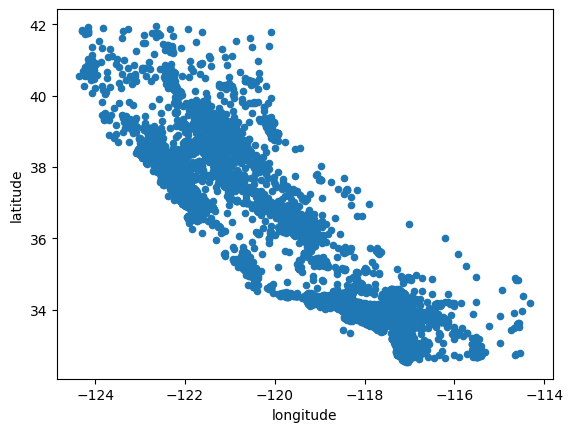

In [30]:
housing.plot(kind='scatter', x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

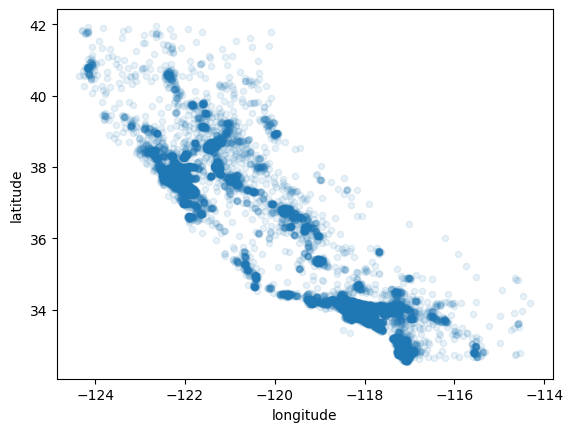

In [31]:
housing.plot(kind='scatter', x="longitude", y="latitude", alpha=0.1)

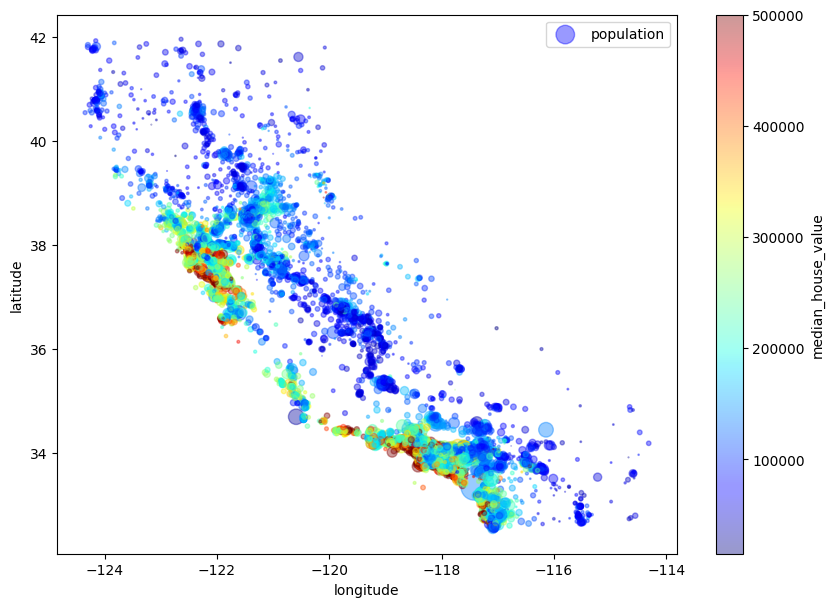

In [32]:
housing.plot(
    kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=housing["population"]/100, label='population', figsize=(10,7), 
    c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()

### 4.2 Looking for correlations

In [33]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105823     0.048909   
latitude            -0.924478  1.000000            0.005737    -0.039245   
housing_median_age  -0.105823  0.005737            1.000000    -0.364535   
total_rooms          0.048909 -0.039245           -0.364535     1.000000   
total_bedrooms       0.076686 -0.072550           -0.325101     0.929391   
population           0.108071 -0.115290           -0.298737     0.855103   
households           0.063146 -0.077765           -0.306473     0.918396   
median_income       -0.019615 -0.075146           -0.111315     0.200133   
median_house_value  -0.047466 -0.142673            0.114146     0.135140   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076686    0.108071    0.063146      -0.019615   
latitude                 -0.072550   -0.115290   -0.077765      -0.075146   
housing_median_age       -0.325101   -0.298737   -0.306473      -0.111315   
total_rooms               0.929391    0.855103    0.918396       0.200133   
total_bedrooms            1.000000    0.876324    0.980167      -0.009643   
population                0.876324    1.000000    0.904639       0.002421   
households                0.980167    0.904639    1.000000       0.010869   
median_income            -0.009643    0.002421    0.010869       1.000000   
median_house_value        0.047781   -0.026882    0.064590       0.687151   

                    median_house_value  
longitude                    -0.047466  
latitude                     -0.142673  
housing_median_age            0.114146  
total_rooms                   0.135140  
total_bedrooms                0.047781  
population                   -0.026882  
households                    0.064590  
median_income                 0.687151  
median_house_value            1.000000

In [34]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

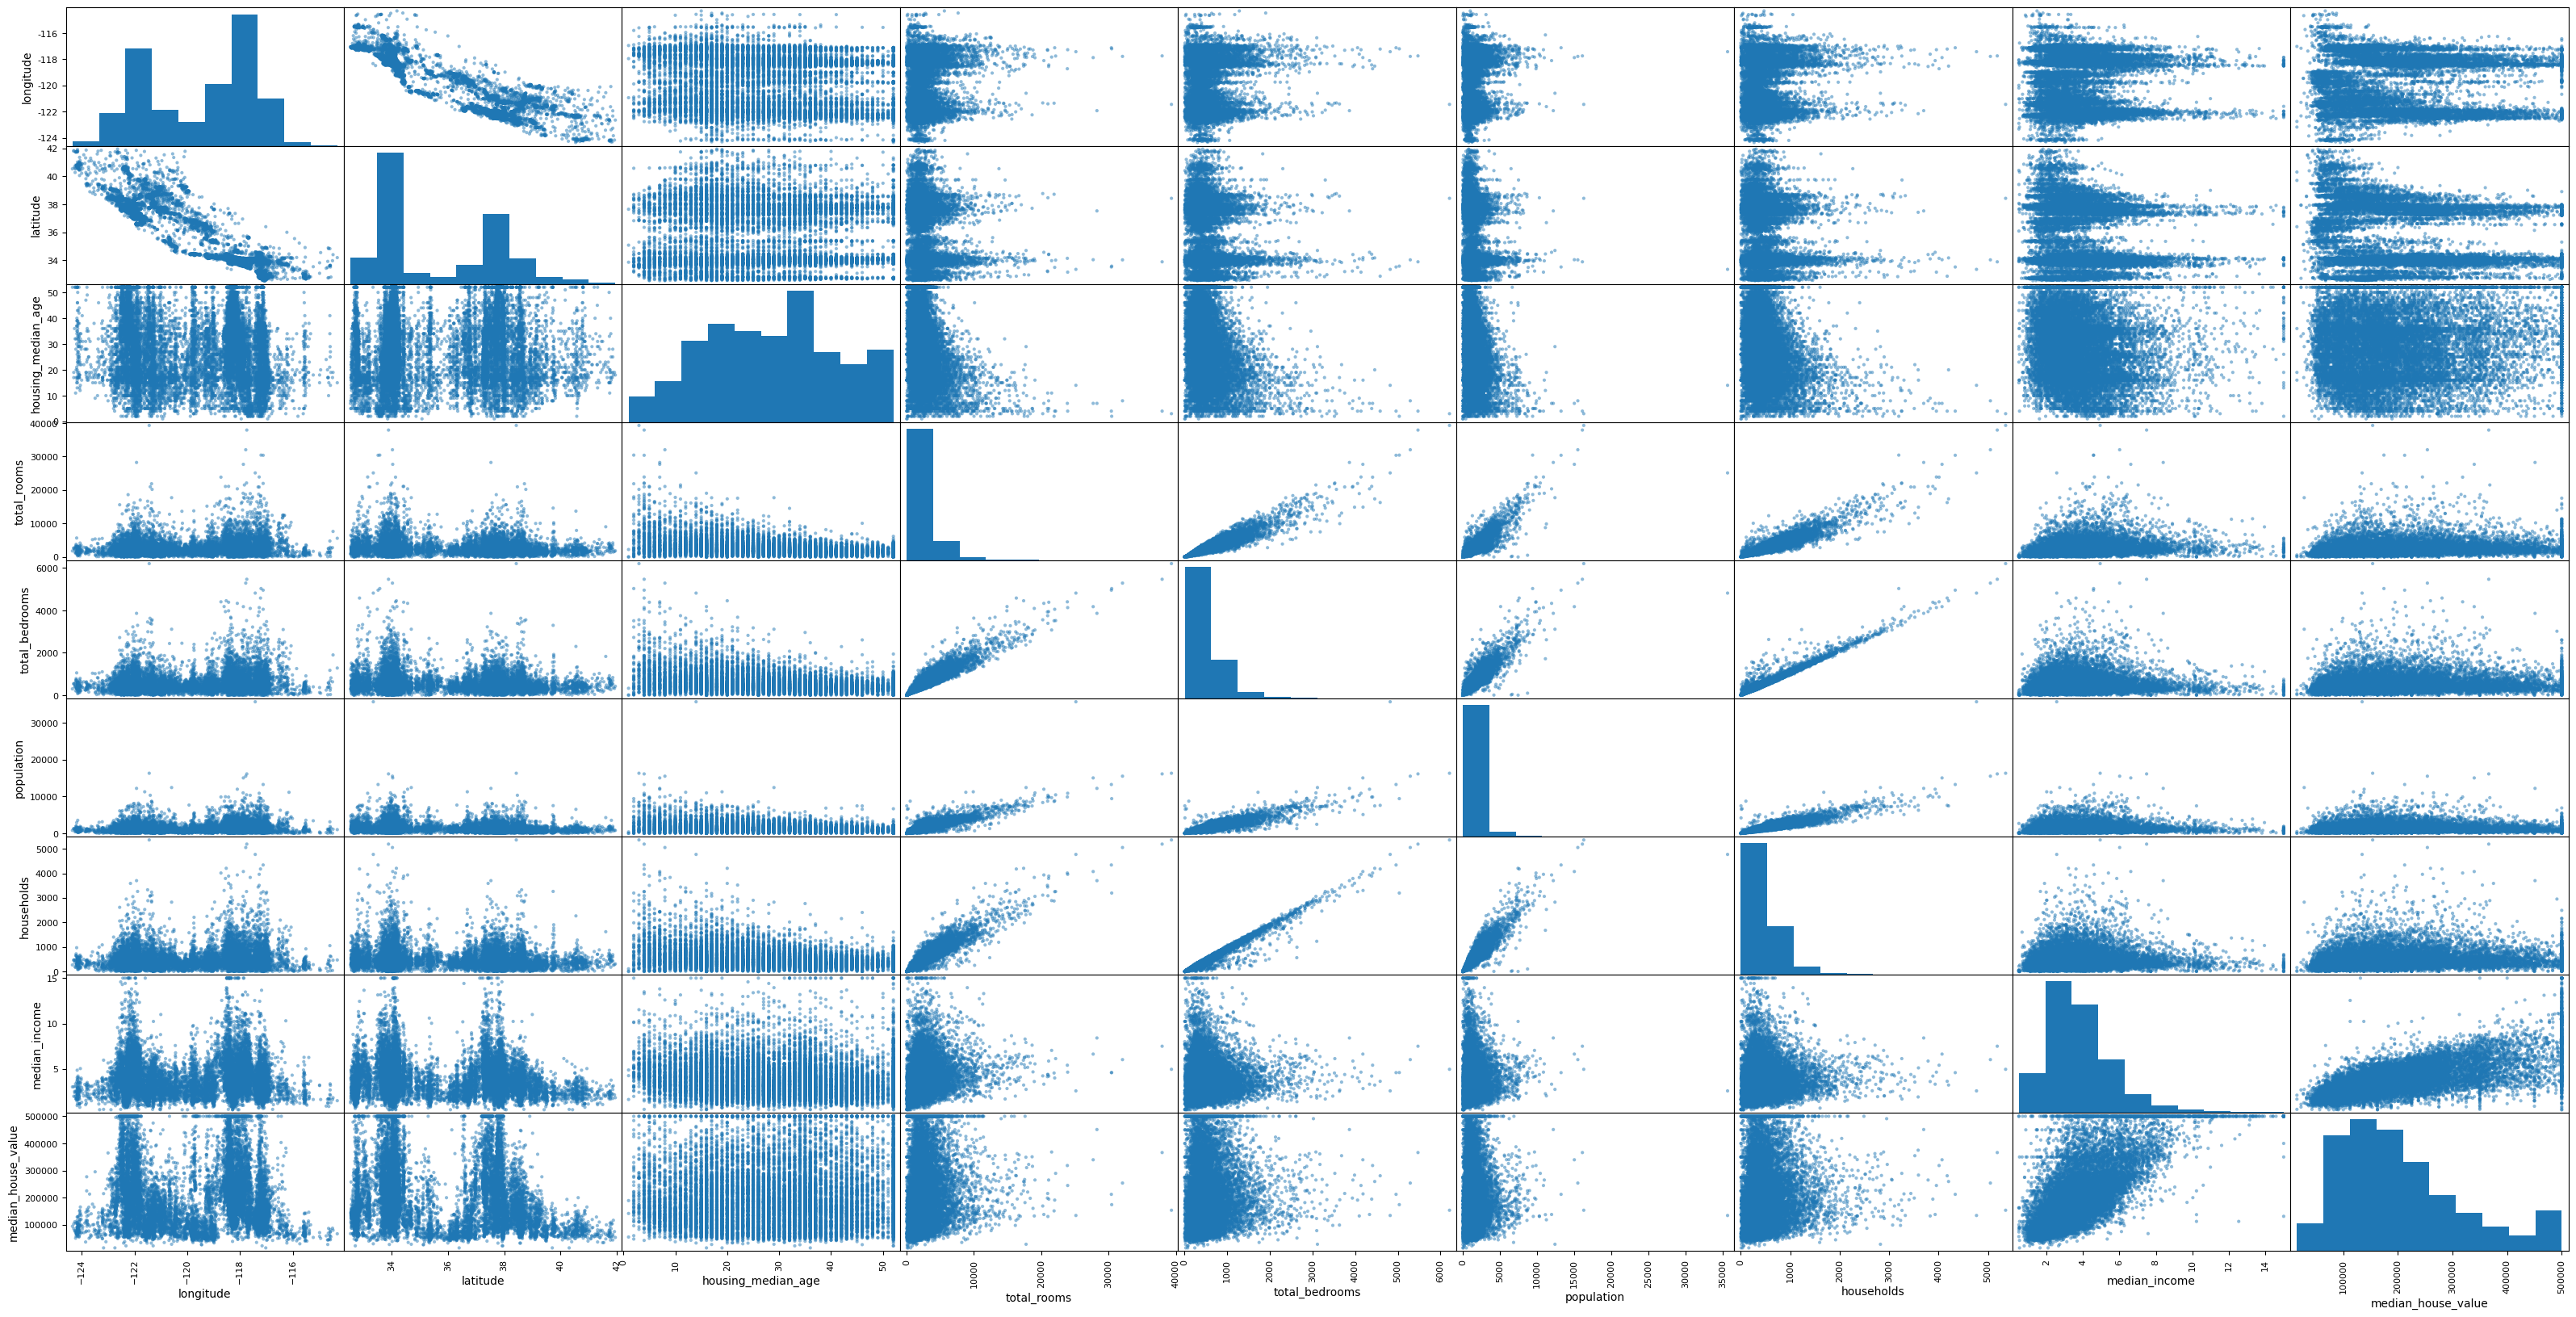

In [35]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing, figsize=(40,20))
plt.show()

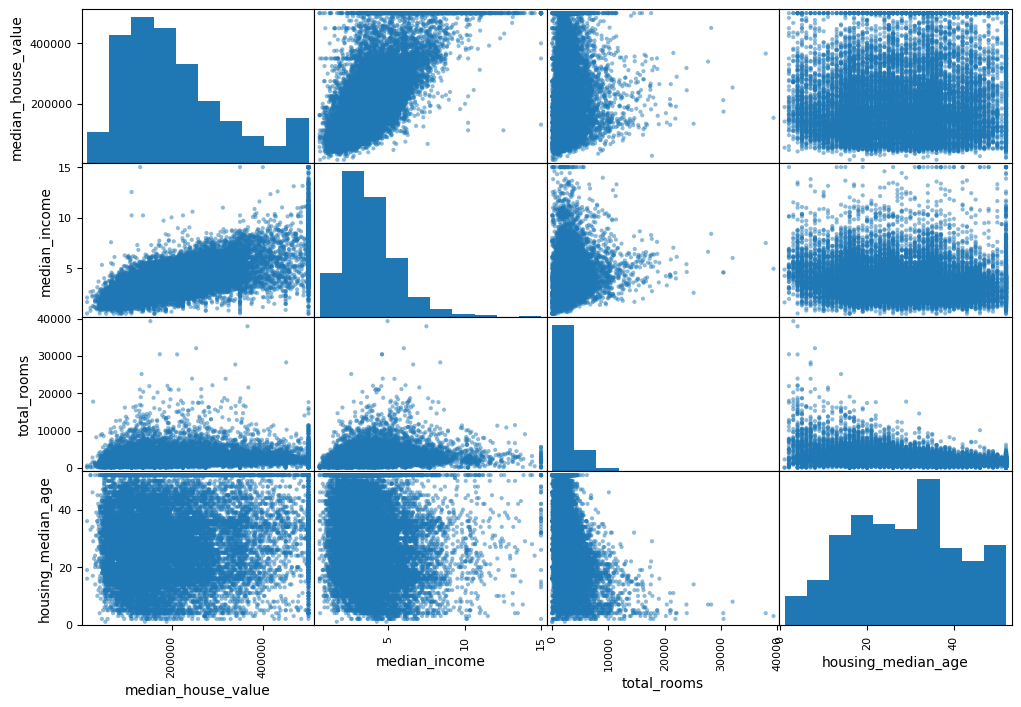

In [36]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

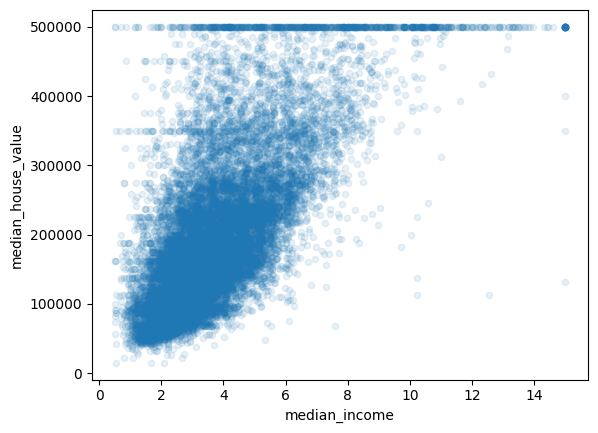

In [37]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### 4.3 Experimenting with Attribute Combinations

In [38]:
housing.info()

<class 'pandas.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.4 MB


In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## 5 Prepare the Data for Machine Learning Algorithms

In [41]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 5.1 Data Cleaning

- To handle missing features

    - Get rid of corresponding districts
    ```python
    housing.dropna(subset=["total_bedrooms"])
    ```
    <br>

    - Get rid of whole attribute
    ```python
    housing.drop("total_bedrooms", axis=1)
    ```
    <br>
    
    - Set values to median
    ```python
    median = housing["total_bedrooms"].median()
    housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)
    ```

In [42]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [43]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [44]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [45]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [46]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [47]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [48]:
X = imputer.transform(housing_num)

In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [50]:
housing["total_bedrooms"].isnull().sum()

np.int64(158)

### 5.2 Handling text and categorical attributes

In [51]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN

In [52]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.]])

In [53]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [54]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [55]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [56]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 5.3 CustomTransformers

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[:5]

array([[-121.46, 38.52, 29.0, 3873.0, 797.0, 2237.0, 706.0, 2.1736,
        'INLAND', 5.485835694050992, 3.168555240793201],
       [-117.23, 33.09, 7.0, 5320.0, 855.0, 2015.0, 768.0, 6.3373,
        'NEAR OCEAN', 6.927083333333333, 2.6236979166666665],
       [-119.04, 35.37, 44.0, 1618.0, 310.0, 667.0, 300.0, 2.875,
        'INLAND', 5.3933333333333335, 2.223333333333333],
       [-117.13, 32.75, 24.0, 1877.0, 519.0, 898.0, 483.0, 2.2264,
        'NEAR OCEAN', 3.886128364389234, 1.8592132505175984],
       [-118.7, 34.28, 27.0, 3536.0, 646.0, 1837.0, 580.0, 4.4964,
        '<1H OCEAN', 6.096551724137931, 3.1672413793103447]], dtype=object)

### 5.4 Feature Scaling

1. **MinMaxScaler** (Min-max scaling or Normalization) = `(x-min)/(max-min)` Range = `[0,1]` hyperparam -> feature_range
2. **StandardScaler** (Standardization) = `(x-mean)/SD` Mean = 0 and SD = 1
<br>

- Unlike min-max scaling, standardization does not bound values to a specific range
- However, standardization is much less affected by outliers
- it is important to fit the scalers tothe training data only, not to the full dataset

### 5.5 Transformation Pipelines

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_added', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr[:5]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521],
       [ 0.43743108, -0.63581817, -0.13148926,  0.42717947,  0.27279028,
         0.37406031,  0.22089846,  0.32575178,  0.2512412 ,  0.00610923,
        -0.47451338]])

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder())
])

housing_cat_tr = cat_pipeline.fit_transform(housing_cat)
housing_cat_tr.toarray()[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[:5]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

## 6 Select and Train a Model

### 6.1 Training and Evaluating on the Training Set

In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [62]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [63]:
print("predictions: ", lin_reg.predict(some_data_prepared))

predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [64]:
print("labels: ", list(some_labels))

labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [65]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68627.87390018745)

In [66]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [67]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

### 6.2 Better Evaluation Using Cross-Validation

In [68]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [69]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("SD: ", scores.std())

In [70]:
display_scores(tree_rmse_scores)

Scores:  [72251.22610062 70811.34799853 68000.08591434 71929.39104752
 69328.61392367 77963.99482744 71628.79228943 73511.78648072
 69045.58722762 69854.4073967 ]
Mean:  71432.52332065887
SD:  2696.6824522410743


In [71]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:  69104.07998247063
SD:  2880.3282098180634


In [72]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [73]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51340.22553753 49240.079874   46976.40445657 51917.1921677
 47035.53338226 51829.80557131 52841.15437862 49525.18429381
 47962.29506428 54069.20606905]
Mean:  50273.7080795117
SD:  2357.685647654302


In [74]:
from sklearn.metrics import mean_squared_error

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18733.78842762556)

In [75]:
comparison_df = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Decision Tree",
        "Random Forest"
    ],
    "Train RMSE": [
        np.sqrt(lin_mse),
        np.sqrt(tree_mse),
        np.sqrt(forest_mse)
    ],
    "CV RMSE Mean": [
        lin_rmse_scores.mean(),
        tree_rmse_scores.mean(),
        forest_rmse_scores.mean()
    ],
    "CV RMSE Std": [
        lin_rmse_scores.std(),
        tree_rmse_scores.std(),
        forest_rmse_scores.std()
    ]
})

comparison_df

Model    Train RMSE  CV RMSE Mean  CV RMSE Std
0  Linear Regression  68627.873900  69104.079982  2880.328210
1      Decision Tree      0.000000  71432.523321  2696.682452
2      Random Forest  18733.788428  50273.708080  2357.685648

### 6.3 Saving model

In [76]:
import joblib

MODELS_PATH = 'models'

os.makedirs(MODELS_PATH, exist_ok=True)

joblib.dump(lin_reg, os.path.join(MODELS_PATH, "linearRegressionModel.pkl"))
joblib.dump(tree_reg, os.path.join(MODELS_PATH, "decisionTreeModel.pkl"))
joblib.dump(forest_reg, os.path.join(MODELS_PATH, "randomForestModel.pkl"))

['models/randomForestModel.pkl']

In [78]:
# later 
linear_model = joblib.load(os.path.join(MODELS_PATH, "linearRegressionModel.pkl"))
linear_model

LinearRegression()

## 7. Fine-Tune Your Model

### 7.1 Grid Search

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap':[False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [80]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [81]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63298.325280791854 {'max_features': 2, 'n_estimators': 3}
55270.34904709105 {'max_features': 2, 'n_estimators': 10}
52764.37907812309 {'max_features': 2, 'n_estimators': 30}
59915.231517953645 {'max_features': 4, 'n_estimators': 3}
52250.00971218671 {'max_features': 4, 'n_estimators': 10}
50523.76956271084 {'max_features': 4, 'n_estimators': 30}
58765.92610607112 {'max_features': 6, 'n_estimators': 3}
51730.966110363326 {'max_features': 6, 'n_estimators': 10}
49946.273624879475 {'max_features': 6, 'n_estimators': 30}
59277.60503739721 {'max_features': 8, 'n_estimators': 3}
52330.73545038374 {'max_features': 8, 'n_estimators': 10}
50227.668503643676 {'max_features': 8, 'n_estimators': 30}
62861.2715675933 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53857.8212549715 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60006.561171063295 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52604.14159908305 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### 7.2 **Randomized Search**
- grid search approach is fine when you are exploring relatively few combinations
- when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead
- instead of trying out all possible combinations
- it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration
- 2 main benifits
    - If you let the randomized search run for say 1000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
    - Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

### 7.3 **Ensemble Method**
- Another way to fine-tune your system is to try to combine the models that perform best
- The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on)
- especially if the individual models make very different types of errors

### 7.4 Analyze the Best Models and Their Errors

In [82]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.02540413e-02, 7.30975513e-02, 4.21462904e-02, 1.94599329e-02,
       1.66305656e-02, 1.82993131e-02, 1.50495682e-02, 3.03111918e-01,
       6.20480248e-02, 1.06221557e-01, 8.14535860e-02, 9.36554568e-03,
       1.67342766e-01, 6.92925556e-05, 1.89090481e-03, 3.55914297e-03])

In [83]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_pipeline = full_pipeline.named_transformers_["cat"]
cat_encoder = cat_pipeline.named_steps["onehot"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3031119176071169), 'median_income'),
 (np.float64(0.16734276601874726), 'INLAND'),
 (np.float64(0.10622155666897516), 'pop_per_hhold'),
 (np.float64(0.0814535860261664), 'bedrooms_per_room'),
 (np.float64(0.08025404133343494), 'longitude'),
 (np.float64(0.07309755133984223), 'latitude'),
 (np.float64(0.06204802478201258), 'rooms_per_hhold'),
 (np.float64(0.04214629041432651), 'housing_median_age'),
 (np.float64(0.019459932868257434), 'total_rooms'),
 (np.float64(0.01829931310645658), 'population'),
 (np.float64(0.016630565643715827), 'total_bedrooms'),
 (np.float64(0.01504956816998999), 'households'),
 (np.float64(0.009365545680866467), '<1H OCEAN'),
 (np.float64(0.003559142973095881), 'NEAR OCEAN'),
 (np.float64(0.001890904811381891), 'NEAR BAY'),
 (np.float64(6.92925556139685e-05), 'ISLAND')]

### 7.5 Evaluate Your System on the Test Set

In [84]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(47491.48557683056)

In [85]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45481.8075141 , 49419.50616749])